#  3-Topic Model of the Constantine Beys Corpus

## Summary Analysis

This is a further simplification and abstraction from the 4-topic model and probably makes the most sense as the most generalized, top level of the hierarchy.

## Experimental Visualizations

In [1]:
import pandas as pd

oa3_topics = pd.Cov = pd.read_csv("/Users/asg/mallet/output/OA-model/oa3-keys.csv", sep=',')
oa3_topics.style.set_properties(subset=['top-words'], **{'width': '600px'})

,topic-num,prop,top-words
0,0,2.33987,bey qu’il faire ville d’une temps alger pacha dey tunis d’alger d’un mort troupes province fils turcs tête nouveau pays
1,1,0.5549,france troupes milice français janissaires région gana hadj l’agha kaïd mokrani alger makhzen sud pacha touggourt sultan biens chaouchs l’autre
2,2,0.29579,général bône colonne ben-gana rue sud enfin chef ville france commandement feu place puis région henanecha s’était bientôt hommes contingents


In [3]:
# Create a list of topic labels.
labels = ['Leadership & Succession','Algerian-Colonial Power Relations','French Invasion']

# Add the labels list as a new column to the dataframe
oa3_topics['labels'] = labels

# Adjust the style of the dataframe so that the column of top_words is wide enough to see all of them.
oa3_topics.style.set_properties(subset=['top-words'], **{'width': '500px'})

,topic-num,prop,top-words,labels
0,0,2.33987,bey qu’il faire ville d’une temps alger pacha dey tunis d’alger d’un mort troupes province fils turcs tête nouveau pays,Leadership & Succession
1,1,0.5549,france troupes milice français janissaires région gana hadj l’agha kaïd mokrani alger makhzen sud pacha touggourt sultan biens chaouchs l’autre,Algerian-Colonial Power Relations
2,2,0.29579,général bône colonne ben-gana rue sud enfin chef ville france commandement feu place puis région henanecha s’était bientôt hommes contingents,French Invasion


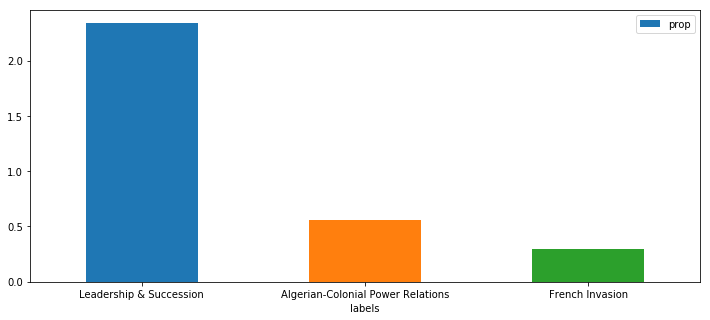

In [4]:
# Represent the weights of the topics as a simple bar chart, using the author-created topic labels. 

topic_bar = oa3_topics.plot.bar(x='labels', y='prop', rot=0, figsize=(12,5))

In [5]:
# The mallet .txt doc-topics output file was converted to a csv, and the columns for 
# document numbers and filepaths were deleted in advance of reading the csv into a 
# pandas dataframe.

oa3_docs = pd.Cov = pd.read_csv("/Users/asg/mallet/output/OA-model/oa3-doc-topics.csv", sep=',')

# Uncomment the following line to view dataframe
oa3_docs

,Leadership & Succession,Algerian-Colonial Power Relations,French Invasion
0,0.467785,0.531707,0.000508
1,0.836108,0.106905,0.056987
2,0.957867,0.027483,0.014650
3,0.681765,0.311132,0.007104
4,0.472133,0.498280,0.029586
5,0.862583,0.089636,0.047781
6,0.643451,0.299562,0.056987
7,0.539958,0.459844,0.000198
8,0.979964,0.008090,0.011945
9,0.581715,0.412885,0.005399


ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

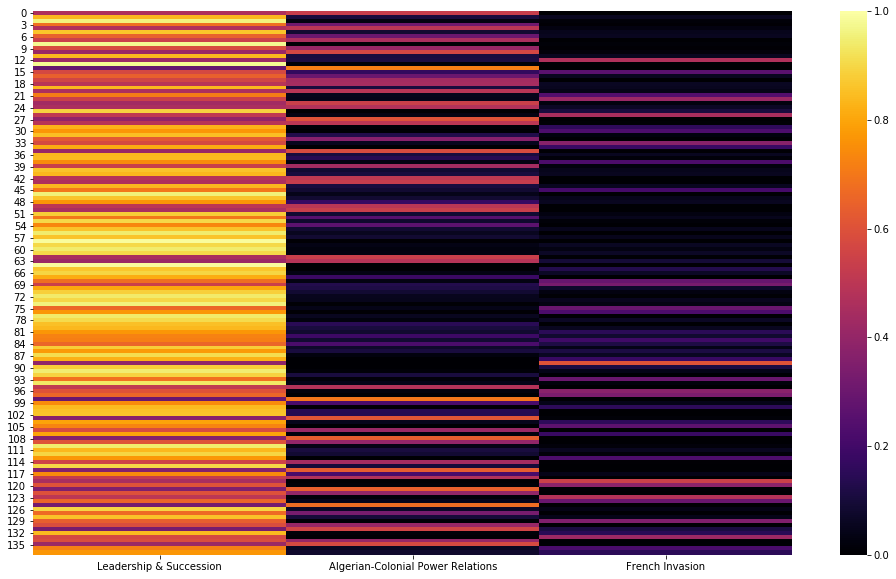

In [6]:
# Represent the topic weights in each document as a heatmap.

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (17.0, 10.0)

oa3_docs = oa3_docs[oa3_docs.columns].astype(float)  # or int

# Create a heatmap that is visually accessible (see https://matplotlib.org/tutorials/colors/colormaps.html)
# using the 'inferno' colormap. 

sns.heatmap(oa3_docs, cmap='inferno', vmin=0.0, vmax=1.0)

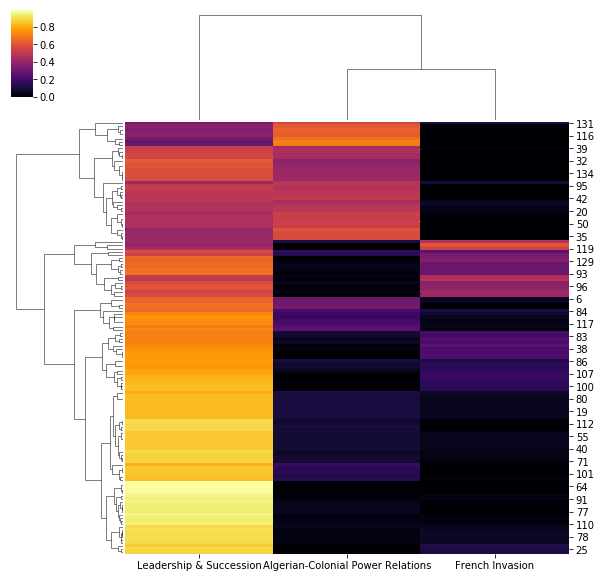

In [7]:
# Create a hierarchical heatmap using seaborn's "clustermap" method with default settings.
# By default this method will cluster by both rows and columns, which is what is most useful for this data.

sns.clustermap(oa3_docs, cmap='inferno')

## Visualizing Mallet output with pyLDAvis
You will need to generate MALLET's output-topic-states <b>gz</b> file to prepare the MALLET output in the format needed by pyLDAvis. I didn't know about this possibility, so I had to run MALLET again, creating a different 5-topic model than the ones visualized above. 

<b>Huge thanks are due to <a href="https://jeriwieringa.com/about/">Jeri E. Wieringa</a> for making this connection and sharing all of the code! You can find her explanation and code at <a href="https://jeriwieringa.com/2018/07/17/pyLDAviz-and-Mallet/">"Using pyLDAvis with Mallet."</a></b>

In [8]:
import pandas as pd
import gzip
import os

dataDir = "/Users/asg/mallet/output/OA-model"

def extract_params(statefile):
    """Extract the alpha and beta values from the statefile. 
    
    Args:
        statefile (str): Path to the statefile produced by Mallet.
    Returns:
        tuple: alpha (list), beta
    """
    with gzip.open(statefile, 'r') as state:
        params = [x.decode('utf-8').strip() for x in state.readlines()[1:3]]
    return (list(params[0].split(":")[1].split(" ")), float(params[1].split(":")[1]))

def state_to_df(statefile):
    """Transform state file into pandas dataframe. 
    The Mallet statefile is tab-separated, and the first two rows contain the alpha and beta hyperparameters.
    
    Args:
        statefile (str): Path to statefile produced by Mallet.
    Returns:
        dataframe: topic assignment for each token in each document of the model
    """
    return pd.read_csv(statefile,
                      compression='gzip',
                      sep=' ',
                      skiprows=[1,2]
                      )

In [9]:
params = extract_params(os.path.join(dataDir, 'oa3-topic-state.gz'))

alpha = [float(x) for x in params[0][1:]]
beta = params[1]
print("{}, {}".format(alpha, beta))

df = state_to_df(os.path.join(dataDir, 'oa3-topic-state.gz'))

[2.339873365896534, 0.554897589034225, 0.2957938795855294], 0.2974504104891835


In [10]:
# Define column 'type' as a string to avoid nan pandas errors.
df['type'] = df.type.astype(str)

# Preview the dataframe from the statefile, which will then be used to generate the data needed for the 
# LDAvis library. 
df[:4]

,#doc,source,pos,typeindex,type,topic
0,0,data/OttAlg/gaid-36.txt,0,0,naaman-bey,0
1,0,data/OttAlg/gaid-36.txt,1,1,mai,0
2,0,data/OttAlg/gaid-36.txt,2,2,turc,0
3,0,data/OttAlg/gaid-36.txt,3,3,naissance,1


<b>Step 1:</b> We need the length of the documents. To do this, Jeri grouped the data by document id and counted the tokens in the doc. This data is then sorted by the doc id, so it will be in the correct order for visualization pre-processing.

In [11]:
# Get document lengths from statefile.
docs = df.groupby('#doc')['type'].count().reset_index(name='doc_length')

# Preview the gathered & grouped data:
docs[:4]

,#doc,doc_length
0,0,579
1,1,2
2,2,17
3,3,320


<b>Step 2:</b> We need the voabulary and frequencies. Jeri used pandas to generate a new frame with the word counts. She then sorted this df so that it is alphabetical by type, a step that will need to be repeated when creating the topic-term matrix because the order matters and must be kept consistent. Just as in Jeri's example, I, too, have OCR errors (see the first entry in the vocab dataframe above).

In [12]:
# Get vocab and term frequencies from the statefile.
vocab = df['type'].value_counts().reset_index()
vocab.columns = ['type', 'term_freq']
vocab = vocab.sort_values(by='type', ascending=True)

# Preview the resulting dataframe
vocab[:4]

,type,term_freq
9186,a*tes,1
12565,a-t-elle,1
4507,a-t-il,3
6754,abaissement,2


<b>Step 3:</b> Create matrix files. The values need to be smoothed and the data normalized so that each row sums to 1. Jeri used sklearn to handle large matrices efficiently. 

In [13]:
# Topic-term matrix from state file.

import sklearn.preprocessing

def pivot_and_smooth(df, smooth_value, rows_variable, cols_variable, values_variable):
    """
    Turns the pandas dataframe into a data matrix.
    Args:
        df (dataframe): aggregated dataframe
        smooth_value (float): value to add to the matrix to account for the priors
        rows_variable (str): name of dataframe row to use as the rows in the matrix
        cols_variable (str): name of dataframe column to use as the columns in the matrix
        values_variable (str): name of the dataframe column to use as the values in the matrix
    Returns:
        dataframe: pandas matrix that has been normalized on the rows
    """
    matrix = df.pivot(index=rows_variable, columns=cols_variable, values=values_variable).fillna(value=0)
    matrix = matrix.values + smooth_value
    normed = sklearn.preprocessing.normalize(matrix, norm='l1', axis=1)
    return pd.DataFrame(normed)

<b>Step 4:</b> [From Jeri's post] Next, we need to aggregate the data from the statefile dataframe to get the nmber of topic assignments for words in the documents. For <b>phi</b>, the topic-term matrix, [she] aggregated by topic and word, counted the number of times each word was assigned to each topic, and then sorted the resulting dataframe alphabetically by word, so that it matches the order of the vocabulary frame. Here, [she] used the <b>beta</b> hyperparameter as the smoothing value.

In [14]:
phi_df = df.groupby(['topic', 'type'])['type'].count().reset_index(name ='token_count')
phi_df = phi_df.sort_values(by='type', ascending=True)

phi_df[:10]

phi = pivot_and_smooth(phi_df, beta, 'topic', 'type', 'token_count')

phi[:10]

,0,1,2,3,4,5,6,7,8,9,...,16790,16791,16792,16793,16794,16795,16796,16797,16798,16799
0,0.000005,0.000023,0.000058,0.000005,0.000005,0.000005,0.000040,0.000110,0.000023,0.000005,...,0.000005,0.000005,0.000023,0.000005,0.000005,0.000058,0.000023,0.000163,0.000040,0.000005
1,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,0.000017,0.000074,0.000017,0.000017,...,0.000017,0.000017,0.000017,0.000074,0.000017,0.000017,0.000131,0.000017,0.000074,0.000074
2,0.000061,0.000014,0.000014,0.000109,0.000061,0.000061,0.000109,0.000061,0.000014,0.000061,...,0.000109,0.000061,0.000014,0.000014,0.000061,0.000014,0.000014,0.000061,0.000061,0.000014


<b>Step 5:</b> We do the same thing again, but focused on the documents and topics (rather than words & topics) to generate the <b>theta</b> document-topic matrix. Here, <b>alpha</b> is used as the smoothing value.

In [15]:
theta_df = df.groupby(['#doc', 'topic'])['topic'].count().reset_index(name ='topic_count')

theta_df[:10]

theta = pivot_and_smooth(theta_df, alpha, '#doc', 'topic', 'topic_count')

theta[:10]

,0,1,2
0,0.467785,0.531707,0.000508
1,0.836108,0.106905,0.056987
2,0.957867,0.027483,0.014650
3,0.681765,0.311132,0.007104
4,0.472133,0.498280,0.029586
5,0.862583,0.089636,0.047781
6,0.643451,0.299562,0.056987
7,0.539958,0.459844,0.000198
8,0.979964,0.008090,0.011945
9,0.581715,0.412885,0.005399


The above processing steps represent about 90% of the work needed to prepare the mallet data for visualization with the LDAvis library. Now that all of the data has been formatted for pyLDAvis, we can queue it up and pass it to the visualization library.

In [16]:
import pyLDAvis

data = {'topic_term_dists': phi,
        'doc_topic_dists': theta,
        'doc_lengths': list(docs['doc_length']),
        'vocab': list(vocab['type']),
        'term_frequency': list(vocab['term_freq'])
}

vis_data = pyLDAvis.prepare(**data)

pyLDAvis.display(vis_data)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
